In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions_NLM import estimate_nested_logit, find_clusters
from functions_IB import information_bottleneck, information_bottleneck_convergence, IB_curve
from functions_geom_DIB import geom_DIB, DIB_curve

In [2]:
# Define log-likelihood function for telephone data
# beta will be beta = ["ASC_1", "ASC_3", "ASC_4", "ASC_5", "BETA_COST", "lambda_measured", "lambda_flat"]

def log_likelihood_telephone(beta, data):
    # Define utility functions
    data['U_1'] = beta[0] + beta[4] * data['logcost1'] 
    data['U_2'] = beta[4] * data['logcost2'] 
    data['U_3'] = beta[1] + beta[4] * data['logcost3']
    data['U_4'] = beta[2] + beta[4] * data['logcost4']
    data['U_5'] = beta[3] + beta[4] * data['logcost5']
    
    # Calculate logsum for nests with > 1 alt
    data['logsum_measured'] = np.log(data['avail1'] * np.exp(data['U_1'] / beta[5])
                                        + data['avail2'] * np.exp(data['U_2'] / beta[5])
                                        + (1 - data['avail1']) * (1 - data['avail2']))
    data['logsum_flat'] = np.log(data['avail3'] * np.exp(data['U_3'] / beta[6])
                                    + data['avail4'] * np.exp(data['U_4'] / beta[6])
                                    + data['avail5'] * np.exp(data['U_5'] / beta[6])
                                    + (1 - data['avail3']) * (1 - data['avail4']) * (1 - data['avail5']))
    
    # Nest probabilities
    data['P_nest_measured'] = np.exp(beta[5] * data['logsum_measured']) / \
                                 (np.exp(beta[5] * data['logsum_measured']) 
                                  + np.exp(beta[6] * data['logsum_flat']))
    data['P_nest_flat'] = 1 - data['P_nest_measured']
    
    # Within nest probabilities for nests with > 1 alt
    data['P_1_in_measured'] = data['avail1'] * np.exp(data['U_1'] / beta[5]) / \
                                (data['avail1'] * np.exp(data['U_1'] / beta[5]) 
                                 + data['avail2'] * np.exp(data['U_2'] / beta[5]))
    data['P_2_in_measured'] = 1 - data['P_1_in_measured']

    data['P_3_in_flat'] = data['avail3'] * np.exp(data['U_3'] / beta[6]) / \
                            (data['avail3'] * np.exp(data['U_3'] / beta[6])
                                + data['avail4'] * np.exp(data['U_4'] / beta[6])
                                + data['avail5'] * np.exp(data['U_5'] / beta[6]))
    data['P_4_in_flat'] = data['avail4'] * np.exp(data['U_4'] / beta[6]) / \
                            (data['avail3'] * np.exp(data['U_3'] / beta[6])
                                + data['avail4'] * np.exp(data['U_4'] / beta[6])
                                + data['avail5'] * np.exp(data['U_5'] / beta[6]))
    data['P_5_in_flat'] = 1 - data['P_3_in_flat'] - data['P_4_in_flat']
    
    # Full probabilities
    data['P_1'] = data['P_nest_measured'] * data['P_1_in_measured']
    data['P_2'] = data['P_nest_measured'] * data['P_2_in_measured']
    data['P_3'] = data['P_nest_flat'] * data['P_3_in_flat']
    data['P_4'] = data['P_nest_flat'] * data['P_4_in_flat']
    data['P_5'] = data['P_nest_flat'] * data['P_5_in_flat']
    
    # Calculate probability for chosen alternative for each row
    data['P'] = (data['choice'] == 1) * data['P_1'] + \
                (data['choice'] == 2) * data['P_2'] + \
                (data['choice'] == 3) * data['P_3'] + \
                (data['choice'] == 4) * data['P_4'] + \
                (data['choice'] == 5) * data['P_5']
    
    # Replace zero probabilities with small value to avoid LL = -inf
    epsilon = 1e-20
    data[data['P'] == 0] = epsilon
    
    # Calculate log-likelihood 
    LL = data['P'].apply(np.log).sum()
    
    return -LL  # We minimize negative log-likelihood

In [3]:
# Load data
subdata = pd.read_csv('./data/telephone.dat', sep='\t')
subdata = subdata[['cost1', 'cost2', 'cost3', 'cost4', 'cost5', 'avail1', 'avail2', 'avail3', 'avail4', 'avail5', 'choice']]

subdata['logcost1'] = np.log(subdata['cost1'])
subdata['logcost2'] = np.log(subdata['cost2'])
subdata['logcost3'] = np.log(subdata['cost3'])
subdata['logcost4'] = np.log(subdata['cost4'])
subdata['logcost5'] = np.log(subdata['cost5'])

subdata = subdata.iloc[:100]

In [4]:
# Estimate parameters
beta = np.array([0, 0, 0, 0, 0, 1, 1])
beta_names = ["ASC_1", "ASC_3", "ASC_4", "ASC_5", "BETA_COST", "lambda_measured", "lambda_flat"]
result_sub, se_sub, t_stat_sub, p_value_sub, aic, bic = estimate_nested_logit(subdata, beta, beta_names, log_likelihood_telephone)

Optimization Results:
         Parameter  Estimate  Robust Asymptotic SE  t-statistic       p-value
0            ASC_1 -0.378246              0.125454    -3.015006  2.723024e-03
1            ASC_3  0.893446              0.171565     5.207627  2.980374e-07
2            ASC_4  0.847293              0.393757     2.151815  3.197195e-02
3            ASC_5  1.405502              0.259374     5.418828  1.004633e-07
4        BETA_COST -1.490024              0.252883    -5.892149  7.739943e-09
5  lambda_measured  0.484798              0.139705     3.470160  5.730726e-04
6      lambda_flat  0.436216              0.121307     3.595981  3.609402e-04
AIC: 960.4386663193137
BIC: 988.9499780580165


<h2> END OF NESTED LOGIT MODEL ESTIMATION </h2>

---
---
---
---
---
---


<h2> BEGINNING OF IB/DIB APPLICATION </h2>

In [5]:
# Computation of p(x) with Monte Carlo 

data_logcost = subdata[['logcost1', 'logcost2', 'logcost3', 'logcost4', 'logcost5']]

# Calculate the sum of the log costs for each row
avail_logcost1 = subdata['avail1'] * subdata['logcost1']
avail_logcost2 = subdata['avail2'] * subdata['logcost2']
avail_logcost3 = subdata['avail3'] * subdata['logcost3']
avail_logcost4 = subdata['avail4'] * subdata['logcost4']
avail_logcost5 = subdata['avail5'] * subdata['logcost5']
data_logcost['sum_logcost'] = avail_logcost1 + avail_logcost2 + avail_logcost3 + avail_logcost4 + avail_logcost5

# Number of Monte Carlo simulations (adjust as needed)
num_simulations = 10000
# Perform Monte Carlo simulation
samples = np.random.choice(data_logcost['sum_logcost'], size=(num_simulations,))
# Count occurrences of each value in the samples
unique_values, counts = np.unique(samples, return_counts=True)
# Normalize counts to obtain probability distribution
probability_distribution = counts / num_simulations
# Create a dictionary to store value-probability pairs
value_probability_dict = dict(zip(unique_values, probability_distribution))

# Add a new column with the probability of each value
data_logcost['probability_MC'] = data_logcost['sum_logcost'].map(value_probability_dict)

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_3245/3731002063.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_logcost['sum_logcost'] = avail_logcost1 + avail_logcost2 + avail_logcost3 + avail_logcost4 + avail_logcost5
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_3245/3731002063.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_logcost['probability_MC'] = data_logcost['sum_logcost'].map(value_probability_dict)


In [6]:
# Computation of p(x,y)

p_x_sub = data_logcost['probability_MC'].values
p_y_given_x_sub = subdata[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].values
p_xy_sub = p_x_sub[:, np.newaxis] * p_y_given_x_sub

# Normalize p_xy 
p_xy_sub /= p_xy_sub.sum()

# Define epsilon value
epsilon = 1e-100

# Add epsilon to elements equal to 0 to avoid numerical issues in the computation of the DIB
p_xy_sub[p_xy_sub == 0] += epsilon

Iteration: 0 out of 20
Iteration: 1 out of 20
Iteration: 2 out of 20
Iteration: 3 out of 20
Iteration: 4 out of 20
Iteration: 5 out of 20
Iteration: 6 out of 20
Iteration: 7 out of 20
Iteration: 8 out of 20
Iteration: 9 out of 20
Iteration: 10 out of 20
Iteration: 11 out of 20
Iteration: 12 out of 20
Iteration: 13 out of 20
Iteration: 14 out of 20
Iteration: 15 out of 20
Iteration: 16 out of 20
Iteration: 17 out of 20
Iteration: 18 out of 20
Iteration: 19 out of 20
Iteration: 0 out of 20
Iteration: 1 out of 20
Iteration: 2 out of 20
Iteration: 3 out of 20
Iteration: 4 out of 20
Iteration: 5 out of 20
Iteration: 6 out of 20
Iteration: 7 out of 20
Iteration: 8 out of 20
Iteration: 9 out of 20
Iteration: 10 out of 20
Iteration: 11 out of 20
Iteration: 12 out of 20
Iteration: 13 out of 20
Iteration: 14 out of 20
Iteration: 15 out of 20
Iteration: 16 out of 20
Iteration: 17 out of 20
Iteration: 18 out of 20
Iteration: 19 out of 20
Iteration: 0 out of 20
Iteration: 1 out of 20
Iteration: 2 o

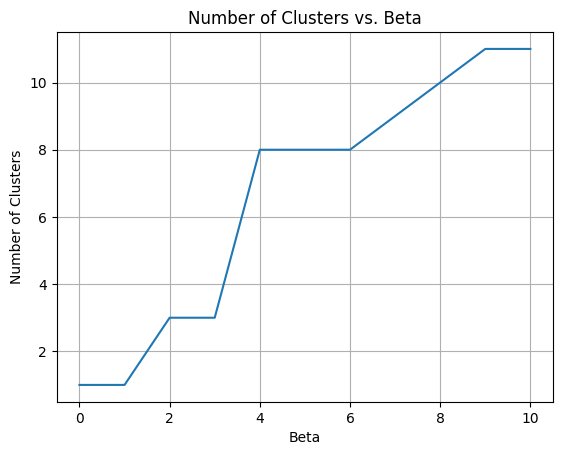

In [49]:
# Plot the number of clusters depending on the beta value

betas = np.linspace(0, 10, 11)
# Initialize an empty list to store the number of clusters
num_clusters_list = []

# Iterate over each beta value
for beta in betas:
    # Run iterative_algorithm to obtain q_t_given_x
    q_t_given_x, _, _ = geom_DIB(p_xy_sub, max_iter=20, beta=beta)
    
    # Calculate the number of clusters
    column_sum = np.sum(q_t_given_x, axis=0)
    num_clusters = np.count_nonzero(column_sum)
    
    # Append the number of clusters to the list
    num_clusters_list.append(num_clusters)

# Plot the number of clusters against beta values
plt.plot(betas, num_clusters_list)
plt.xlabel('Beta')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. Beta')
plt.grid(True)
plt.show()

In [7]:
q_t_given_x_sub, q_t_sub, q_y_given_t_sub = geom_DIB(p_xy_sub, beta=10, max_iter=100)

Iteration: 0 out of 100
Iteration: 1 out of 100
Iteration: 2 out of 100
Iteration: 3 out of 100
Iteration: 4 out of 100
Iteration: 5 out of 100
Iteration: 6 out of 100
Iteration: 7 out of 100
Iteration: 8 out of 100
Iteration: 9 out of 100
Iteration: 10 out of 100
Iteration: 11 out of 100
Iteration: 12 out of 100
Iteration: 13 out of 100
Iteration: 14 out of 100
Iteration: 15 out of 100
Iteration: 16 out of 100
Iteration: 17 out of 100
Iteration: 18 out of 100
Iteration: 19 out of 100
Iteration: 20 out of 100
Iteration: 21 out of 100
Iteration: 22 out of 100
Iteration: 23 out of 100
Iteration: 24 out of 100
Iteration: 25 out of 100
Iteration: 26 out of 100
Iteration: 27 out of 100
Iteration: 28 out of 100
Iteration: 29 out of 100
Iteration: 30 out of 100
Iteration: 31 out of 100
Iteration: 32 out of 100
Iteration: 33 out of 100
Iteration: 34 out of 100
Iteration: 35 out of 100
Iteration: 36 out of 100
Iteration: 37 out of 100
Iteration: 38 out of 100
Iteration: 39 out of 100
Iteration:

In [8]:
# Find clusters
cluster_dict = find_clusters(q_t_given_x_sub)

# Create DataFrame with row index and cluster number
df = pd.DataFrame.from_dict(cluster_dict, orient='index', columns=['Cluster'])

# Set index name
df.index.name = 'Row Index'

# Reindex the DataFrame to have row index from 0 to n
df = df.reindex(range(len(q_t_given_x_sub)))

# Count the number of unique clusters
num_clusters = len(set(cluster_dict.values()))

# Print the number of clusters
print("Number of clusters:", num_clusters)


Number of clusters: 12


In [9]:
# Create new column choice_nest which is 1 if choice = 1 or 2, and 2 otherwise
subdata['choice_nest'] = np.where(subdata['choice'].isin([1, 2]), 1, 2)
subdata['cluster'] = df['Cluster']
subdata['cluster'].value_counts()

cluster
2     33
1     25
6     14
4      9
3      5
7      5
5      4
8      1
9      1
10     1
11     1
12     1
Name: count, dtype: int64

In [10]:
subdata['choice_nest'].value_counts()

choice_nest
2    64
1    36
Name: count, dtype: int64

In [14]:
data_results = subdata[['P_nest_measured','P_nest_flat', 'P_1','P_2', 'P_3', 'P_4', 'P_5', 'choice', 'choice_nest', 'cluster']]

data_results['max_proba'] = data_results[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].idxmax(axis=1).str[-1].astype(int)

#create a dataframe from mismatched_rows
data_results = pd.DataFrame(data_results)

# pd.set_option('display.max_rows', None)  # Set the maximum number of rows to display to None
# pd.set_option('display.max_columns', None) 
# Print the mismatched rows
data_results.head()

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_3245/3577568185.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_results['max_proba'] = data_results[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].idxmax(axis=1).str[-1].astype(int)


,P_nest_measured,P_nest_flat,P_1,P_2,P_3,P_4,P_5,choice,choice_nest,cluster,max_proba
0,0.529566,0.470434,0.204125,0.325441,0.359397,0.0,0.111037,2,1,1,3
1,0.700634,0.299366,0.536981,0.163653,0.234107,0.0,0.065260,3,2,2,1
2,0.532928,0.467072,0.263076,0.269852,0.411247,0.0,0.055825,1,1,2,3
3,0.501056,0.498944,0.275753,0.225302,0.451343,0.0,0.047602,3,2,2,3
4,0.444273,0.555727,0.112749,0.331523,0.444681,0.0,0.111046,3,2,1,3


In [15]:
# number of each alternative 1, 2, 3, 4, 5 in each cluster 
cluster_counts = data_results.groupby(['cluster', 'choice']).size().unstack(fill_value=0)
cluster_counts

choice,1,2,3,4,5
cluster,,,,,
1,1,5,16,0,3
2,13,6,12,0,2
3,0,1,4,0,0
4,0,0,3,0,6
5,0,0,4,0,0
6,3,6,5,0,0
7,0,0,0,0,5
8,0,0,0,1,0
9,1,0,0,0,0


In [16]:
cluster_counts2 = data_results.groupby(['cluster', 'max_proba']).size().unstack(fill_value=0)
cluster_counts2

max_proba,1,2,3,4,5
cluster,,,,,
1,0,3,22,0,0
2,14,0,19,0,0
3,0,0,5,0,0
4,0,0,0,0,9
5,0,0,4,0,0
6,0,0,14,0,0
7,0,0,0,0,5
8,0,0,0,1,0
9,0,0,1,0,0


In [17]:
nest_counts = data_results.groupby(['choice', 'max_proba']).size().unstack(fill_value=0)
nest_counts

max_proba,1,2,3,4,5
choice,,,,,
1,6,0,12,0,0
2,2,1,15,0,0
3,5,1,36,0,3
4,0,0,1,1,0
5,1,1,3,0,12


---
---
---
---
---
---

<h2> Trying IB </h2>

In [20]:
information_bottleneck_convergence(p_xy_sub, beta=4, max_iter=100, threshold=1e-6)

Iteration 1


Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47


(array([[1.30542197e-02, 1.17772984e-02, 1.32216464e-02, ...,
         7.33072461e-03, 1.29020074e-02, 1.45777374e-02],
        [1.30961265e-02, 1.18150374e-02, 1.32640519e-02, ...,
         7.35368789e-03, 1.29433979e-02, 1.46246269e-02],
        [1.30636253e-02, 1.17857665e-02, 1.32311629e-02, ...,
         7.33586192e-03, 1.29112963e-02, 1.45882641e-02],
        ...,
        [2.99379626e-09, 2.98001608e-09, 2.99560693e-09, ...,
         2.93206678e-09, 2.99215509e-09, 3.01023821e-09],
        [1.28377118e-02, 1.15820008e-02, 1.30023804e-02, ...,
         7.20941191e-03, 1.26880371e-02, 1.43359184e-02],
        [6.16692928e-03, 5.56374978e-03, 6.24605059e-03, ...,
         3.46350677e-03, 6.09504248e-03, 6.88658649e-03]]),
 array([0.01092817, 0.00985921, 0.01106833, 0.00866901, 0.00621678,
        0.00680379, 0.0129949 , 0.0077341 , 0.01087954, 0.00692814,
        0.00731291, 0.0054236 , 0.00398518, 0.00485953, 0.00943673,
        0.00970705, 0.01263126, 0.01396226, 0.01216474, 0.009

Computing mutual information for beta 1 out of 101
Iteration 1
Iteration 2
Computing mutual information for beta 2 out of 101
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Computing mutual information for beta 3 out of 101
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Computing mutual information for beta 4 out of 101
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iter

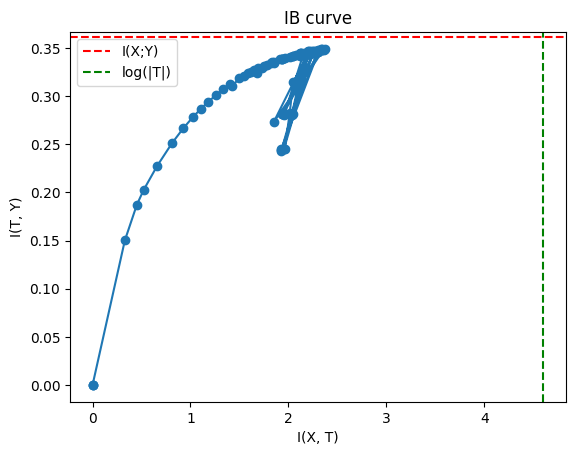

In [22]:
betas = np.linspace(0, 100, 101)
IB_curve(p_xy_sub, beta_values=betas, max_iter=50, algorithm=information_bottleneck_convergence)